# Parameter Optimization Results Analysis

This notebook analyzes the results from the parameter optimization pipeline demo.

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## Load Results

In [2]:
# Load results
results_dir = Path('../output/param_opt_results')

# Load complete results
with open(results_dir / 'complete_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Load summary
summary_df = pd.read_csv(results_dir / 'exposure_summary.csv')
print(f"Loaded results for {len(summary_df)} exposures")
summary_df

Loaded results for 16 exposures


,exposure,total_return,inflation,real_rf_rate,risk_premium,volatility,risk_method,expected_return
0,us_large_equity,0.155835,0.041525,-0.015674,0.130191,0.145659,optimal,0.160191
1,us_small_equity,0.116922,0.041525,-0.015674,0.091279,0.199285,optimal,0.121279
2,intl_developed_large_equity,0.068950,0.041525,-0.015674,0.043306,0.118400,optimal,0.073306
3,intl_developed_small_equity,0.056545,0.041525,-0.015674,0.030901,0.120257,optimal,0.060901
4,emerging_equity,0.048517,0.041525,-0.015674,0.022874,0.139678,optimal,0.052874
5,factor_style_equity,0.126004,0.041525,-0.015674,0.100361,0.064824,optimal,0.130361
6,factor_style_other,0.130764,0.041525,-0.015674,0.105120,0.103162,optimal,0.135120
7,trend_following,0.070008,0.041525,-0.015674,0.044365,0.070572,optimal,0.074365
8,cash_rate,0.025643,0.041525,-0.015674,0.000000,NaN,NaN,0.030000
9,short_ust,0.008568,0.041525,-0.015674,-0.017076,0.012307,optimal,0.012924


## Return Decomposition Analysis

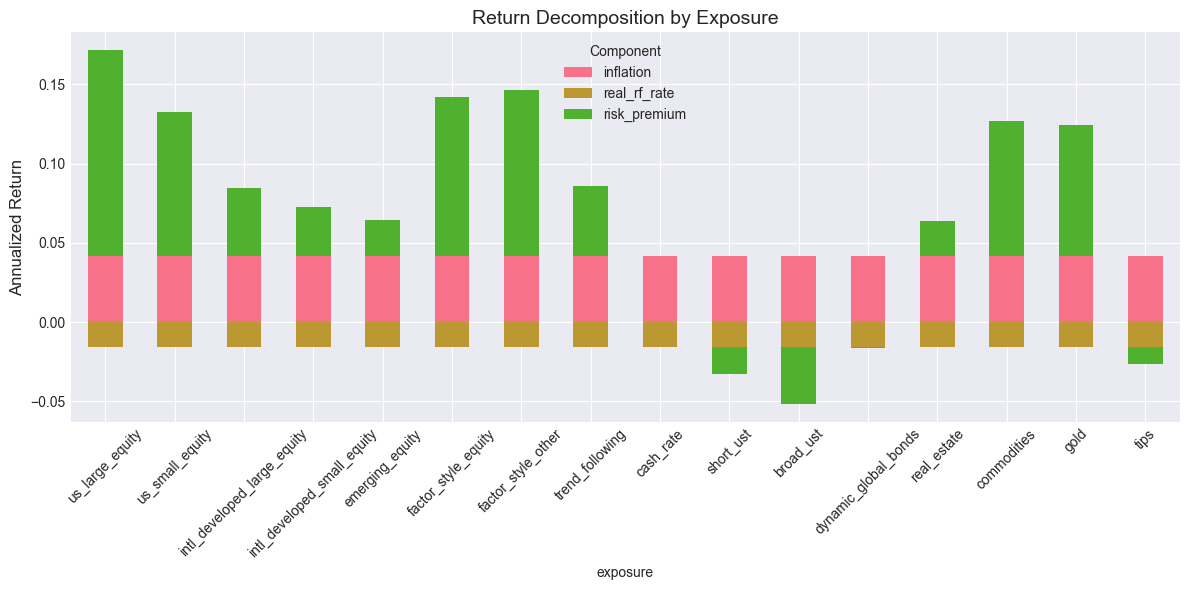

In [3]:
# Analyze return decomposition
decomp_cols = ['total_return', 'inflation', 'real_rf_rate', 'risk_premium']
decomp_df = summary_df[['exposure'] + decomp_cols].set_index('exposure')

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
decomp_df[['inflation', 'real_rf_rate', 'risk_premium']].plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Return Decomposition by Exposure', fontsize=14)
ax.set_ylabel('Annualized Return', fontsize=12)
ax.legend(title='Component')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Risk Estimates Analysis

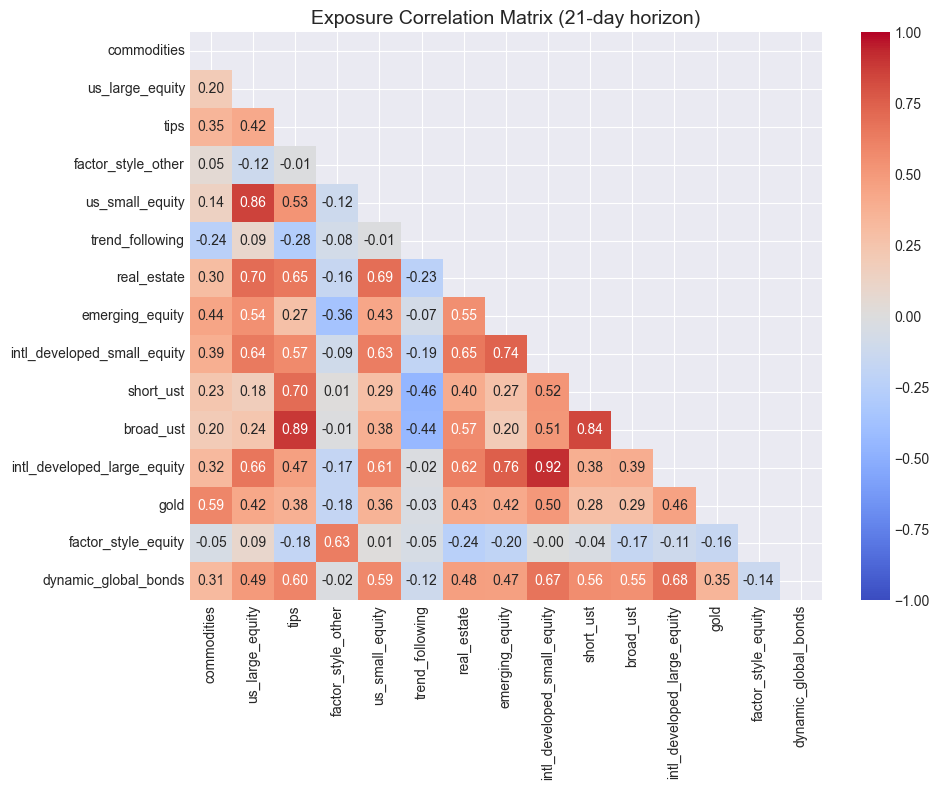

In [4]:
# Check if correlation matrix exists
corr_file = results_dir / 'correlation_matrix.csv'
if corr_file.exists():
    # Load correlation matrix
    corr_matrix = pd.read_csv(corr_file, index_col=0)
    
    # Visualize correlation matrix
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(f'Exposure Correlation Matrix ({results["optimal_horizon"]}-day horizon)', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Correlation matrix not available - using individual volatility estimates")
    
    # Plot volatilities
    vol_data = summary_df[['exposure', 'volatility']].set_index('exposure')
    plt.figure(figsize=(10, 6))
    vol_data.plot(kind='bar', legend=False)
    plt.title('Exposure Volatilities', fontsize=14)
    plt.ylabel('Annualized Volatility', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Risk-Return Scatter

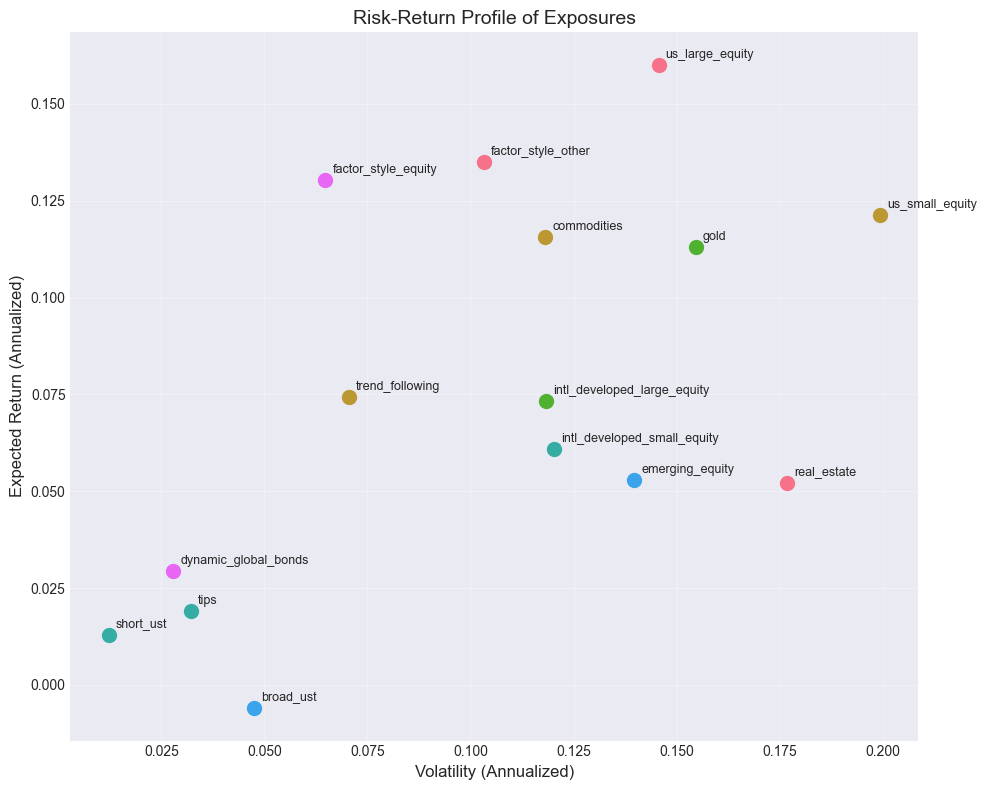

In [5]:
# Create risk-return scatter plot
plt.figure(figsize=(10, 8))

# Plot exposures
for idx, row in summary_df.iterrows():
    plt.scatter(row['volatility'], row['expected_return'], s=100)
    plt.annotate(row['exposure'], (row['volatility'], row['expected_return']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Volatility (Annualized)', fontsize=12)
plt.ylabel('Expected Return (Annualized)', fontsize=12)
plt.title('Risk-Return Profile of Exposures', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Detailed Exposure Analysis

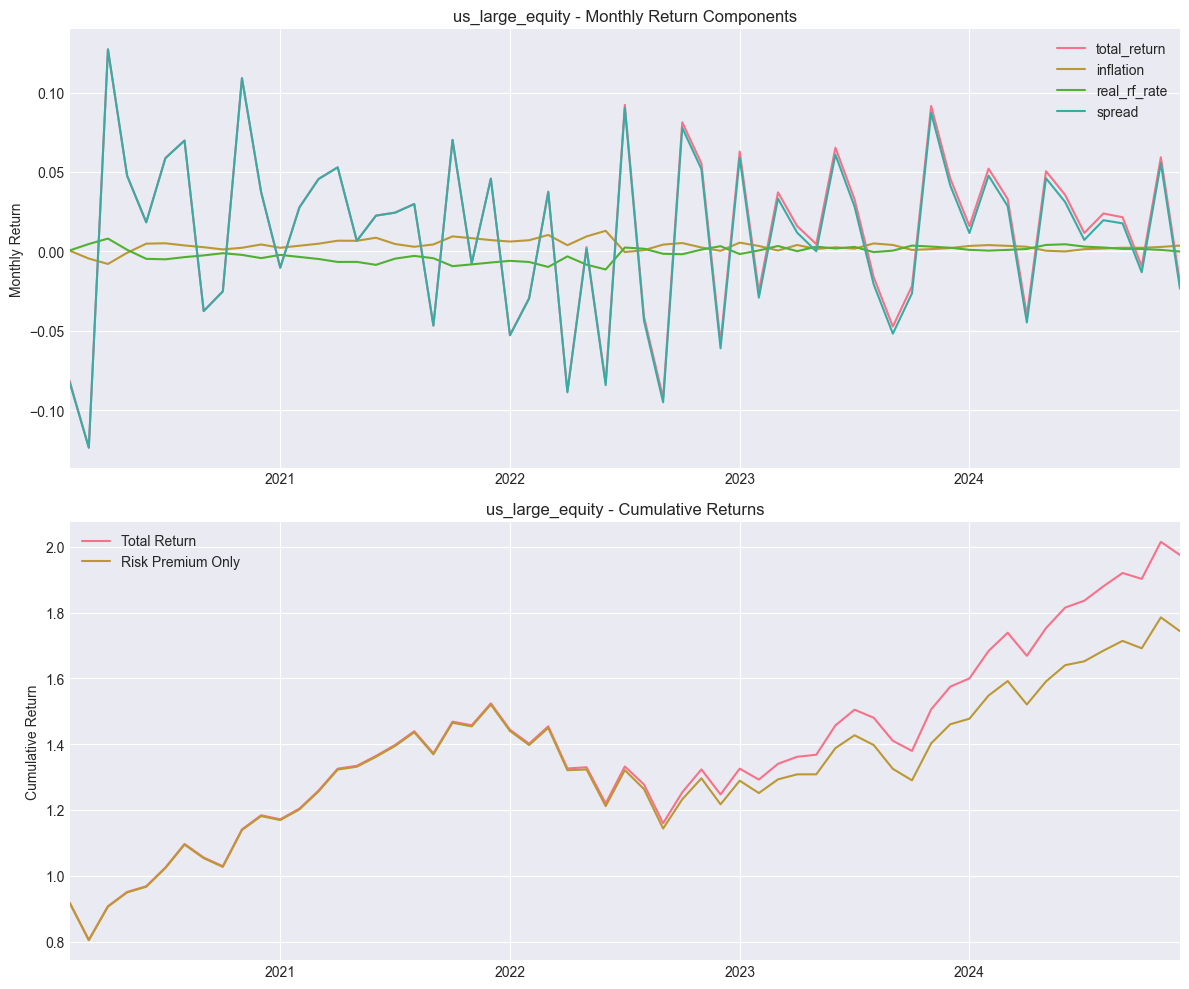

In [6]:
# Select an exposure to analyze in detail
exposure_id = 'us_large_equity'

# Check if decomposition time series exists
decomp_file = results_dir / f'decomposition_{exposure_id}.csv'
if decomp_file.exists():
    # Load time series decomposition
    decomp_ts = pd.read_csv(decomp_file, index_col=0, parse_dates=True)
    
    # Plot time series
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot returns
    decomp_ts[['total_return', 'inflation', 'real_rf_rate', 'spread']].plot(ax=axes[0])
    axes[0].set_title(f'{exposure_id} - Monthly Return Components', fontsize=12)
    axes[0].set_ylabel('Monthly Return')
    axes[0].legend(loc='best')
    
    # Plot cumulative returns
    cumulative = (1 + decomp_ts[['total_return', 'spread']]).cumprod()
    cumulative.plot(ax=axes[1])
    axes[1].set_title(f'{exposure_id} - Cumulative Returns', fontsize=12)
    axes[1].set_ylabel('Cumulative Return')
    axes[1].legend(['Total Return', 'Risk Premium Only'])
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Time series data not available for {exposure_id}")
    
    # Show summary statistics instead
    exp_summary = summary_df[summary_df['exposure'] == exposure_id]
    if not exp_summary.empty:
        print(f"\nSummary for {exposure_id}:")
        for col in exp_summary.columns:
            if col != 'exposure':
                print(f"  {col}: {exp_summary[col].iloc[0]:.3f}")

## Parameter Optimization Results

In [7]:
# Display optimization results
print(f"Optimal Forecast Horizon: {results['optimal_horizon']} days")
print("\nParameter Optimization Summary:")
if 'parameter_optimization' in results:
    for key, value in results['parameter_optimization'].items():
        print(f"\n{key}:")
        if isinstance(value, dict) and len(value) > 10:
            # Show subset of large dictionaries
            print(f"  {len(value)} items (showing first 5):")
            for i, (k, v) in enumerate(value.items()):
                if i >= 5:
                    break
                print(f"    {k}: {v}")
        else:
            print(json.dumps(value, indent=2))

Optimal Forecast Horizon: 21 days

Parameter Optimization Summary:

global_settings:
{
  "forecast_horizon": 21,
  "optimization_date": "2025-07-12",
  "optimization_method": "horizon_aware",
  "total_combinations_tested": 40,
  "best_combined_score": -0.96019940247135
}

method_selection:
{
  "default_method": "ewma",
  "best_frequency": "weekly",
  "selection_criteria": "lowest_combined_score"
}

validation_summary:
{
  "target_horizon": 21,
  "total_results": 40,
  "best_combined_score": -0.96019940247135,
  "best_volatility_mse": 0.00019067671387761246,
  "best_hit_rate": 0.2738095238095238,
  "frequency_analysis": {
    "daily": {
      "count": 20,
      "avg_score": -0.8101531322553296
    },
    "weekly": {
      "count": 20,
      "avg_score": -0.9046896136871576
    }
  },
  "lambda_analysis": {
    "0.9": {
      "count": 8,
      "avg_score": -0.801896742306689
    },
    "0.92": {
      "count": 8,
      "avg_score": -0.8274757882470208
    },
    "0.94": {
      "count": 

## Summary Statistics

In [8]:
# Calculate summary statistics
print("PORTFOLIO OPTIMIZATION RESULTS SUMMARY")
print("=" * 50)

# Overall statistics
n_exposures = len(summary_df)
avg_return = summary_df['expected_return'].mean()
avg_volatility = summary_df['volatility'].mean()
avg_risk_premium = summary_df['risk_premium'].mean()

print(f"Number of Exposures: {n_exposures}")
print(f"Average Expected Return: {avg_return:.1%}")
print(f"Average Volatility: {avg_volatility:.1%}")
print(f"Average Risk Premium: {avg_risk_premium:.1%}")

# Risk-return efficiency
summary_df['sharpe_ratio'] = (summary_df['expected_return'] - 0.03) / summary_df['volatility']  # Assuming 3% RF
best_sharpe = summary_df.loc[summary_df['sharpe_ratio'].idxmax()]
print(f"\nBest Sharpe Ratio: {best_sharpe['exposure']} ({best_sharpe['sharpe_ratio']:.2f})")

# Asset class breakdown
print("\nExposure Analysis:")
for _, row in summary_df.iterrows():
    print(f"  {row['exposure']}: {row['expected_return']:.1%} return, {row['volatility']:.1%} vol")

print(f"\nResults saved to: {results_dir}")
print("\nFiles available for further analysis:")
for file in sorted(results_dir.glob('*')):
    print(f"  - {file.name}")

PORTFOLIO OPTIMIZATION RESULTS SUMMARY
Number of Exposures: 16
Average Expected Return: 7.3%
Average Volatility: 10.2%
Average Risk Premium: 4.3%

Best Sharpe Ratio: factor_style_equity (1.55)

Exposure Analysis:
  us_large_equity: 16.0% return, 14.6% vol
  us_small_equity: 12.1% return, 19.9% vol
  intl_developed_large_equity: 7.3% return, 11.8% vol
  intl_developed_small_equity: 6.1% return, 12.0% vol
  emerging_equity: 5.3% return, 14.0% vol
  factor_style_equity: 13.0% return, 6.5% vol
  factor_style_other: 13.5% return, 10.3% vol
  trend_following: 7.4% return, 7.1% vol
  cash_rate: 3.0% return, nan% vol
  short_ust: 1.3% return, 1.2% vol
  broad_ust: -0.6% return, 4.8% vol
  dynamic_global_bonds: 2.9% return, 2.8% vol
  real_estate: 5.2% return, 17.7% vol
  commodities: 11.6% return, 11.8% vol
  gold: 11.3% return, 15.5% vol
  tips: 1.9% return, 3.2% vol

Results saved to: ../output/param_opt_results

Files available for further analysis:
  - complete_results.pkl
  - correlation_